In [134]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
sns.set()
%matplotlib inline

import scipy.stats

In [241]:
# Constants
mean = 0; std = 1; trunc_std = 2
p = 0.5
lambd = 2
alpha = 0.25
delta = 0.05

In [242]:
# Distribution
TruncNormal = scipy.stats.truncnorm(-trunc_std, trunc_std, loc=mean, scale=std)
Bernoulli = scipy.stats.bernoulli(p)
Normal = scipy.stats.norm(mean, std)

In [243]:
# True CVaR with 1e7 samples

In [244]:
def estimate_cvar(dist, alpha, n=int(1e7)):
    # Numerical Calculation of CVaR
    rvs = np.hstack([dist.rvs(size=n)]) 
    x = np.sort(rvs)
    estCVaR = np.sum(x[0: int(n*alpha)]) / (int(n*alpha) + 1)
    return estCVaR

In [245]:
Normal_CVaR = estimate_cvar(Normal, alpha, n=int(1e7))
TruncNormal_CVaR = estimate_cvar(TruncNormal, alpha, n=int(1e7))
Bernoulli_CVaR = estimate_cvar(Bernoulli, alpha, n=int(1e7))

In [246]:
# Estimating ECDF

In [247]:
class ecdf():
    def __init__(self, samples, delta, kwargs):
        self.samples = samples
        self.sorted_samples = sorted(self.samples)
        self.delta = delta
        self.maxV = kwargs['maxV']
        self.reward_range = kwargs['reward_range']
        
        if kwargs['name'] == "Gaussian":
            self.sigma = kwargs['sigma']
            self.name = "Gaussian"
        elif kwargs['name'] == "Bernoulli":
            self.val1 = kwargs['val1']
            self.val2 = kwargs['val2']
            self.name = "Bernoulli"
        
    def empirical_cvar(self, alpha): 
        cvar_samples = self.sorted_samples[:int(np.floor(len(self.samples) * alpha))]
        return sum(cvar_samples) / len(cvar_samples)

    def empirical_var(self, alpha):
        return self.sorted_samples[int(np.floor(len(self.samples) * alpha))]
    
    def dkw_down_cvars(self, alpha):
        optimistic_cvars = 0.0
        dkw_band_width = np.sqrt(np.log(2 / delta) / (2 * len(self.samples)))
        
        num_samples_to_displace = np.ceil(len(self.samples) * dkw_band_width)
        num_samples_to_displace = min(num_samples_to_displace, len(self.samples))

        # Create set of samples which yield optimistic empirical CDF.
        optimistic_samples = np.copy(self.samples)
        optimistic_samples.sort()
        for i in range(int(num_samples_to_displace)):
            optimistic_samples[i] = self.maxV
        optimistic_samples.sort()

        # CVaR is average of samples in the tail.
        num_samples_for_cvar = int(np.floor(alpha * len(optimistic_samples)))
        if num_samples_for_cvar:
            optimistic_cvars = sum(optimistic_samples[:num_samples_for_cvar]) / num_samples_for_cvar
        else:
            # If there are no samples for CVaR, we need more samples.
            optimistic_cvars = self.maxV
        return optimistic_cvars
    
    def colt_cvars(self, alpha, iteration=None):
        
        if iteration is None:
            iteration = len(self.samples)
            
        if self.name == "Gaussian":
            sigma = self.sigma
        elif self.name == "Bernoulli":
            sigma = abs(self.val1-self.val2)

        a = min(2, 1 / (sigma**2) )
        b = 1 / alpha * (1 + 3 * self.reward_range / (min(alpha, 1 - alpha)))
        q = 2  # CVaR-specific constant.

        def phi_inv(x):
            return max(2 * b * (x / a) ** (0.5), 2 * b * (x / a) ** (q / 2.0))

        optimistic_cvars = 0.0
        optimistic_cvars = self.empirical_cvar(alpha)
        # we do iteration + 1 because they assume you start at 1
        optimistic_cvars += phi_inv(alpha * np.log(iteration + 1) / ( (iteration) * len(self.samples)))
        return optimistic_cvars
    
    def brown_cvars(self, alpha, iteration=None):
        
        if iteration is None:
            iteration = len(self.samples)
            
        optimistic_cvars = 0.0
        optimistic_cvars = self.empirical_cvar(alpha)
        optimistic_cvars += self.reward_range * np.sqrt( 5 / (alpha * len(self.samples)) * np.log(3 / delta))
        return optimistic_cvars

In [248]:
def custom_plot(results, true, num_samples, name, fontsize=15, zoom = None, ylim = None, dkw=False, num=None, ylog=False):
    mpl.rc('text', usetex = True)
    plt.figure(figsize = (10,5))
    plt.plot(num_samples, np.mean(results['dkw'], axis=1), marker='.', label = 'dkw', color = 'blue', markersize = 10)
    plt.plot(num_samples, np.mean(results['brown'], axis=1), marker='.', label = 'brown', color = 'green', markersize = 10)
    plt.plot(num_samples, np.mean(results['colt'], axis=1), marker='.', label = 'colt', color = 'black', markersize = 10)
    
    plt.plot(np.arange(num_samples[-1]), np.ones(num_samples[-1]) * true, '--', label = 'true CVaR')
    plt.title(r'Distribution: %s, $\alpha$ = %g'%(name, alpha), fontsize=fontsize)
    plt.xlabel('Number of Samples', fontsize=fontsize)
    plt.ylabel('CVaR', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    if ylog:
        plt.yscale('log')
    if zoom is not None:
        plt.xlim(zoom)
    if ylim is not None:
        plt.ylim(ylim)
    if dkw:
        plt.figure(figsize = (10,5))
        plt.plot(num_samples[:num], np.mean(results['dkw'], axis=1)[:num], marker='.', label = 'dkw', color = 'blue', markersize = 10)
        plt.plot(np.arange(num_samples[:num][-1]), np.ones(num_samples[:num][-1]) * true, '--', label = 'true CVaR')
        plt.title(r'Distribution: %s, $\alpha$ = %g'%(name, alpha), fontsize=fontsize)
        plt.xlabel('Number of Samples', fontsize=fontsize)
        plt.ylabel('CVaR', fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.legend(fontsize=fontsize)
        

In [249]:
# Build ECDFs Truncated Normal

In [250]:
num_samples = [100, 200, 500, 1000, 1500, 3000, 5000, 6000, 7000, 9000, 10000]
trial = 100
opt_cvars = {'brown': np.zeros((len(num_samples), trial)),\
            'colt': np.zeros((len(num_samples), trial)),\
            'dkw': np.zeros((len(num_samples), trial))}
counter = 0
for n in num_samples:
    for t in range(trial):
        Normal_ECDF = ecdf(TruncNormal.rvs(size=n), delta = 0.05,\
                   kwargs = {'reward_range': 2*trunc_std, 'name': 'Gaussian', 'sigma': std, 'maxV':trunc_std})
        opt_cvars['dkw'][counter, t] = Normal_ECDF.dkw_down_cvars(alpha)
        opt_cvars['brown'][counter, t] = Normal_ECDF.brown_cvars(alpha)
        opt_cvars['colt'][counter, t] = Normal_ECDF.colt_cvars(alpha)
    counter += 1

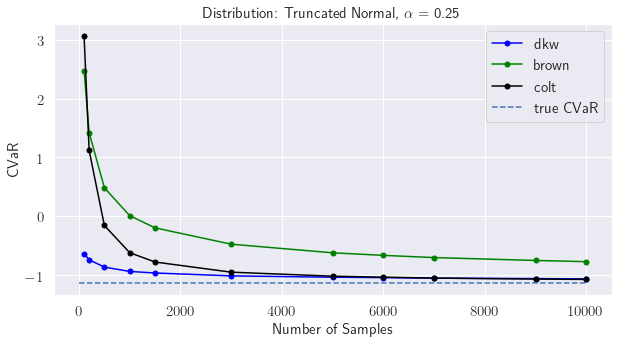

In [251]:
custom_plot(opt_cvars, TruncNormal_CVaR, num_samples, 'Truncated Normal')

In [252]:
# Build ECDFs Truncated Normal

In [253]:
num_samples = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70,\
               100, 200, 500, 1000, 1500]#, 3000, 5000, 6000, 7000, 9000, 10000]
trial = 200
opt_cvars = {'brown': np.zeros((len(num_samples), trial)),\
            'colt': np.zeros((len(num_samples), trial)),\
            'dkw': np.zeros((len(num_samples), trial))}
counter = 0
for n in num_samples:
    for t in range(trial):
        Bernoulli_ECDF = ecdf(Bernoulli.rvs(size=n), delta = 0.05,\
                   kwargs = {'reward_range': 2*trunc_std, 'name': 'Bernoulli', 'val1': 0, 'val2': 1, 'maxV': 1})
        opt_cvars['dkw'][counter, t] = Bernoulli_ECDF.dkw_down_cvars(alpha)
        opt_cvars['brown'][counter, t] = Bernoulli_ECDF.brown_cvars(alpha)
        opt_cvars['colt'][counter, t] = Bernoulli_ECDF.colt_cvars(alpha)
    counter += 1

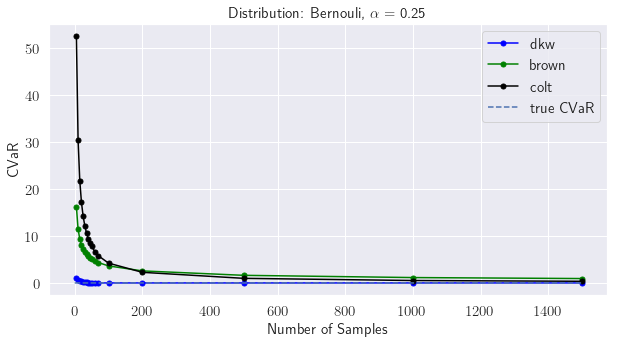

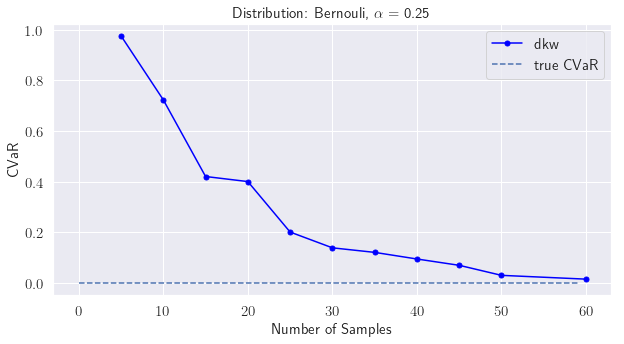

In [254]:
custom_plot(opt_cvars, Bernoulli_CVaR, num_samples, 'Bernouli', dkw=True, num = 11, ylog=False)

In [255]:
num_samples = [100, 200, 500, 1000, 1500, 3000, 5000, 6000, 7000, 9000, 10000]
trial = 100
opt_cvars = {'brown': np.zeros((len(num_samples), trial)),\
            'colt': np.zeros((len(num_samples), trial)),\
            'dkw': np.zeros((len(num_samples), trial))}
counter = 0
for n in num_samples:
    for t in range(trial):
        Normal_ECDF = ecdf(Normal.rvs(size=n), delta = 0.05,\
                   kwargs = {'reward_range': 2*trunc_std, 'name': 'Gaussian', 'sigma': std, 'maxV':1e7})
        opt_cvars['dkw'][counter, t] = Normal_ECDF.dkw_down_cvars(alpha)
        opt_cvars['brown'][counter, t] = Normal_ECDF.brown_cvars(alpha)
        opt_cvars['colt'][counter, t] = Normal_ECDF.colt_cvars(alpha)
    counter += 1

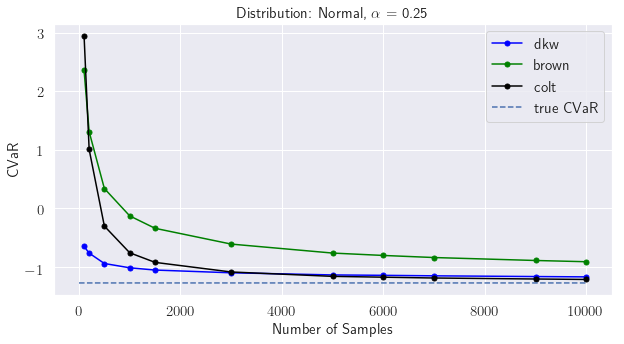

In [256]:
custom_plot(opt_cvars, Normal_CVaR, num_samples, 'Normal')

# Random Shit

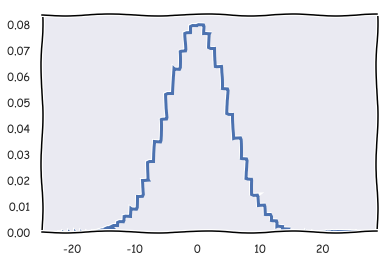

In [325]:
#plt.xkcd()
data = scipy.stats.norm.rvs(loc=0, scale = 5, size=500000)
N, bins, patches = plt.hist(data, density=True, bins=50, histtype='step', linewidth=3);
var = sorted(data)[int(np.floor(len(data) * 0.1))]
dVar = np.argmax(bins[bins<=var])
#for i in range(dVar):
#    patches[i].set_facecolor('orange')
#plt.vlines(-8.772884562613292, 0, 0.07, linewidth=3, color='red', linestyles='dashed')
#plt.show()

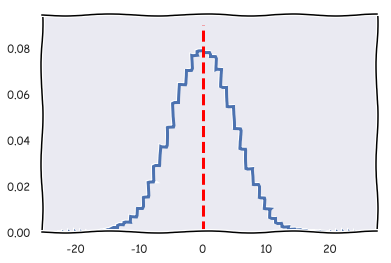

In [326]:
plt.xkcd()
data = scipy.stats.norm.rvs(loc=0, scale = 5, size=500000)
N, bins, patches = plt.hist(data, density=True, bins=50, histtype='step', linewidth=3);
var = sorted(data)[int(np.floor(len(data) * 0.1))]
dVar = np.argmax(bins[bins<=var])
#for i in range(dVar):
#    patches[i].set_facecolor('orange')
plt.vlines(0, 0, 0.09, linewidth=3, color='red', linestyles='dashed')
#plt.show()

<BarContainer object of 18 artists>

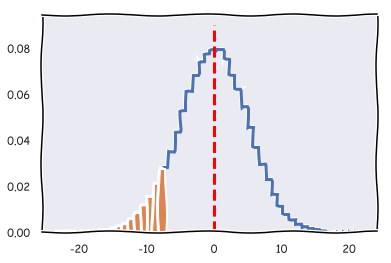

In [327]:
plt.xkcd()
data = scipy.stats.norm.rvs(loc=0, scale = 5, size=500000)
N, bins, patches = plt.hist(data, density=True, bins=50, histtype='step', linewidth=3);
var = sorted(data)[int(np.floor(len(data) * 0.1))]
dVar = np.argmax(bins[bins<=var])
#for i in range(dVar):
#    patches[i].set_facecolor('orange')
plt.vlines(0, 0, 0.09, linewidth=3, color='red', linestyles='dashed')
plt.bar(bins[:dVar], N[:dVar])
#plt.show()

<BarContainer object of 19 artists>

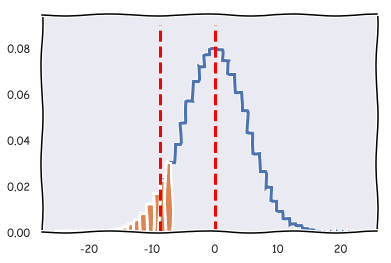

In [328]:
plt.xkcd()
data = scipy.stats.norm.rvs(loc=0, scale = 5, size=500000)
N, bins, patches = plt.hist(data, density=True, bins=50, histtype='step', linewidth=3);
var = sorted(data)[int(np.floor(len(data) * 0.1))]
dVar = np.argmax(bins[bins<=var])
#for i in range(dVar):
#    patches[i].set_facecolor('orange')
plt.vlines(0, 0, 0.09, linewidth=3, color='red', linestyles='dashed')
plt.vlines(-8.7, 0, 0.09, linewidth=3, color='red', linestyles='dashed')
plt.bar(bins[:dVar], N[:dVar])
#plt.show()

<BarContainer object of 18 artists>

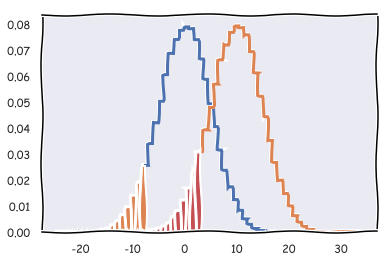

In [343]:
plt.xkcd()
data = scipy.stats.norm.rvs(loc=0, scale = 5, size=500000)
N, bins, patches = plt.hist(data, density=True, bins=50, histtype='step', linewidth=3);
var = sorted(data)[int(np.floor(len(data) * 0.1))]
dVar = np.argmax(bins[bins<=var])
#for i in range(dVar):
#    patches[i].set_facecolor('orange')
#plt.vlines(0, 0, 0.09, linewidth=3, color='red', linestyles='dashed')
#plt.vlines(-8.7, 0, 0.09, linewidth=3, color='red', linestyles='dashed')
plt.bar(bins[:dVar], N[:dVar])
#plt.show()


data = scipy.stats.norm.rvs(loc=0, scale = 5, size=500000)
shift = 10
data += shift
N, bins, patches = plt.hist(data, density=True, bins=50, histtype='step', linewidth=3);
var = sorted(data)[int(np.floor(len(data) * 0.1))]
dVar = np.argmax(bins[bins<=var])
#for i in range(dVar):
#    patches[i].set_facecolor('orange')
#plt.vlines(0, 0, 0.09, linewidth=3, color='red', linestyles='dashed')
#plt.vlines(-8.7, 0, 0.09, linewidth=3, color='red', linestyles='dashed')
plt.bar(bins[:dVar], N[:dVar])
#plt.show()

<BarContainer object of 16 artists>

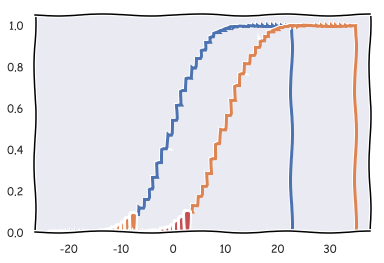

In [342]:
plt.xkcd()
data = scipy.stats.norm.rvs(loc=0, scale = 5, size=500000)
N, bins, patches = plt.hist(data, density=True, bins=50, histtype='step', linewidth=3, cumulative=1);
var = sorted(data)[int(np.floor(len(data) * 0.1))]
dVar = np.argmax(bins[bins<=var])
#for i in range(dVar):
#    patches[i].set_facecolor('orange')
#plt.vlines(0, 0, 1, linewidth=3, color='red', linestyles='dashed')
#plt.vlines(-8.7, 0, 1, linewidth=3, color='red', linestyles='dashed')
plt.bar(bins[:dVar], N[:dVar])


data = scipy.stats.norm.rvs(loc=0, scale = 5, size=500000)
shift = 10
data += shift
N, bins, patches = plt.hist(data, density=True, bins=50, histtype='step', linewidth=3, cumulative=1);
var = sorted(data)[int(np.floor(len(data) * 0.1))]
dVar = np.argmax(bins[bins<=var])
#for i in range(dVar):
#    patches[i].set_facecolor('orange')
#plt.vlines(0 + shift, 0, 1, linewidth=1.5, color='red', linestyles='dashed')
#plt.vlines(-8.7 + shift, 0, 1, linewidth=1.5, color='red', linestyles='dashed')
plt.bar(bins[:dVar], N[:dVar])
#plt.show()

<BarContainer object of 19 artists>

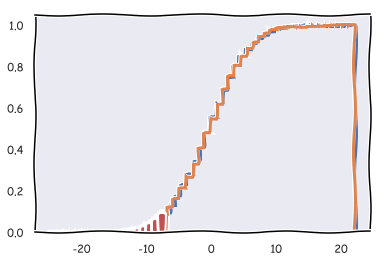

In [352]:
plt.xkcd()
data = scipy.stats.norm.rvs(loc=0, scale = 5, size=500000)
N, bins, patches = plt.hist(data, density=True, bins=50, histtype='step', linewidth=3, cumulative=1);
var = sorted(data)[int(np.floor(len(data) * 0.1))]
dVar = np.argmax(bins[bins<=var])
#for i in range(dVar):
#    patches[i].set_facecolor('orange')
#plt.vlines(0, 0, 1, linewidth=3, color='red', linestyles='dashed')
#plt.vlines(-8.7, 0, 1, linewidth=3, color='red', linestyles='dashed')
plt.bar(bins[:dVar], N[:dVar])


data = scipy.stats.norm.rvs(loc=0, scale = 5, size=500000)
shift = 0.1
#data = np.clip(data, 0, None)
N, bins, patches = plt.hist(data, density=True, bins=50, histtype='step', linewidth=3, cumulative=1);
var = sorted(data)[int(np.floor(len(data) * 0.1))]
dVar = np.argmax(bins[bins<=var])
#for i in range(dVar):
#    patches[i].set_facecolor('orange')
#plt.vlines(0 + shift, 0, 1, linewidth=1.5, color='red', linestyles='dashed')
#plt.vlines(-8.7 + shift, 0, 1, linewidth=1.5, color='red', linestyles='dashed')
plt.bar(bins[:dVar], N[:dVar])
#plt.show()

In [353]:
N

array([2.00000e-06, 6.00000e-06, 1.20000e-05, 1.80000e-05, 4.60000e-05,
       7.40000e-05, 1.48000e-04, 2.88000e-04, 6.66000e-04, 1.21000e-03,
       2.21000e-03, 3.86200e-03, 6.68600e-03, 1.10360e-02, 1.79680e-02,
       2.76520e-02, 4.17120e-02, 6.13200e-02, 8.78680e-02, 1.21318e-01,
       1.63052e-01, 2.13534e-01, 2.71196e-01, 3.35954e-01, 4.05800e-01,
       4.78886e-01, 5.52720e-01, 6.24460e-01, 6.92202e-01, 7.54178e-01,
       8.09122e-01, 8.55818e-01, 8.93602e-01, 9.23714e-01, 9.46748e-01,
       9.63898e-01, 9.76306e-01, 9.85008e-01, 9.90692e-01, 9.94502e-01,
       9.96860e-01, 9.98200e-01, 9.99034e-01, 9.99510e-01, 9.99768e-01,
       9.99902e-01, 9.99972e-01, 9.99988e-01, 9.99998e-01, 1.00000e+00])